In [1]:
from datasets import load_dataset, load_metric   
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline
import matplotlib.pyplot as plt
import torch
import numpy as np

c:\Users\91959\Desktop\Personal\projects\transformers\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://opus.nlpl.eu/KDE4.php
data = load_dataset(path="Helsinki-NLP/kde4", lang1="en", lang2="hi", trust_remote_code=True)

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 97227
    })
})

In [4]:
small = data["train"].shuffle(seed=42).select(range(10000))

In [5]:
small

Dataset({
    features: ['id', 'translation'],
    num_rows: 10000
})

In [6]:
split = small.train_test_split(seed=42)

In [7]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 2500
    })
})

In [8]:
split["train"][0]

{'id': '62116',
 'translation': {'en': 'Finished downloads', 'hi': 'संपन्न डाउनलोड्स'}}

In [9]:
checkpoint = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=checkpoint)

In [10]:
en = split["train"][7]['translation']['en']
hi = split["train"][7]['translation']['hi']
en, hi

('Please enter a float value between %1 and %2',
 'कृपया एक फ्लोट मूल्य भरें% 1 तथा% 2 के बीच')

In [11]:
inputs = tokenizer(text=en)
inputs

{'input_ids': [711, 1163, 19, 17272, 1147, 576, 833, 10, 3670, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
#tokenizing the target sentence
targets = tokenizer(text_target = hi)
targets

{'input_ids': [681, 38, 21087, 2238, 3067, 785, 180, 1231, 785, 332, 6, 484, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
#each sentence ends with a <\s> tag
tokenizer.convert_ids_to_tokens(ids=targets["input_ids"])

['▁कृपया',
 '▁एक',
 '▁फ्लोट',
 '▁मूल्य',
 '▁भरें',
 '%',
 '▁1',
 '▁तथा',
 '%',
 '▁2',
 '▁के',
 '▁बीच',
 '</s>']

In [14]:
#using tokenizer on targets incorrectly
wrong_targets = tokenizer(text=hi)
wrong_targets

{'input_ids': [44, 1, 2703, 1321, 260, 44, 1042, 716, 44, 3663, 1185, 800, 917, 2136, 44, 1056, 3561, 800, 1185, 1321, 44, 7817, 428, 174, 549, 785, 180, 44, 1, 260, 785, 332, 44, 906, 44, 1400, 130, 4228, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
# english tokenizer splits hindi words at weird points
tokenizer.convert_ids_to_tokens(ids=wrong_targets['input_ids'])

['▁',
 '<unk>',
 'प',
 'य',
 'ा',
 '▁',
 'ए',
 'क',
 '▁',
 'फ',
 '्',
 'ल',
 'ो',
 'ट',
 '▁',
 'म',
 'ू',
 'ल',
 '्',
 'य',
 '▁',
 'भ',
 'र',
 'े',
 'ं',
 '%',
 '▁1',
 '▁',
 '<unk>',
 'ा',
 '%',
 '▁2',
 '▁',
 'के',
 '▁',
 'ब',
 'ी',
 'च',
 '</s>']

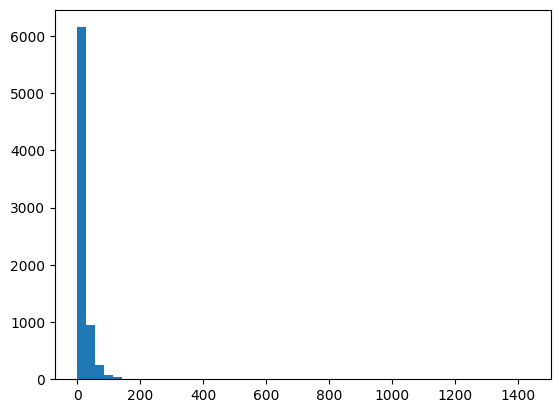

In [16]:
#plotting histogram to determine truncation length
train = split["train"]["translation"]
input_lengths = [len(element['en']) for element in train]

plt.hist(x=input_lengths, bins=50)
plt.show()

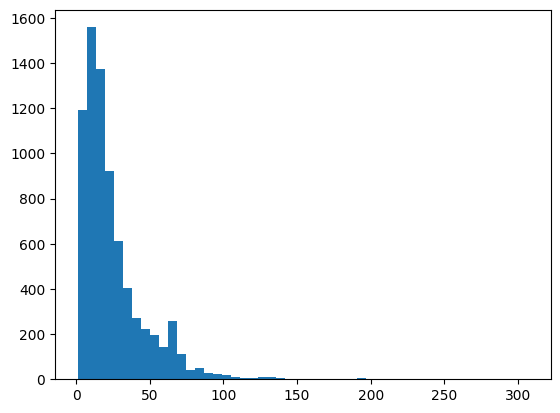

In [17]:
# histogram for target lengths
target_lengths = [len(element['hi']) for element in train]

plt.hist(x=target_lengths, bins=50)
plt.show()

In [18]:
max_input_length = 128
max_target_length = 128

def tokenize_fn(batch):
    inputs = [x['en'] for x in batch['translation']]
    targets = [x['hi'] for x in batch['translation']]
    tokenized_inputs = tokenizer(text=inputs, max_length=max_input_length, truncation=True)
    tokenized_targets = tokenizer(text_target=targets, max_length=max_target_length, truncation=True)
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    return tokenized_inputs

In [19]:
tokenized_datasets = split.map(
    function=tokenize_fn,
    batched=True,
    remove_columns=split['train'].column_names
)

Map: 100%|██████████| 2500/2500 [00:00<00:00, 11049.88 examples/s]


In [20]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2500
    })
})

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model_name_or_path=checkpoint)

In [23]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [24]:
[tokenized_datasets['train'][i] for i in range(2)]

[{'input_ids': [21372, 11909, 0],
  'attention_mask': [1, 1, 1],
  'labels': [13049, 13955, 0]},
 {'input_ids': [30139, 3771, 26309, 1328, 1328, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1],
  'labels': [6, 69, 24825, 0]}]

In [25]:
batch = data_collator(features=[tokenized_datasets['train'][i] for i in range(5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [26]:
# -100 for ignoring tokens
batch['labels']

tensor([[13049, 13955,     0,  -100,  -100,  -100],
        [    6,    69, 24825,     0,  -100,  -100],
        [ 3303,    18,   495,   179,   679,     0],
        [ 1212,  1434,     0,  -100,  -100,  -100],
        [26424,     0,  -100,  -100,  -100,  -100]])

In [27]:
#shifted version of the targets. Padded with the 61949 tokens in beginning and in place of -100
batch['decoder_input_ids']

tensor([[61949, 13049, 13955,     0, 61949, 61949],
        [61949,     6,    69, 24825,     0, 61949],
        [61949,  3303,    18,   495,   179,   679],
        [61949,  1212,  1434,     0, 61949, 61949],
        [61949, 26424,     0, 61949, 61949, 61949]])

In [28]:
# both input and target vocabs share one ID space and hence unique tokens, so the tokenizer can decode both languages.
# this also means that there is no hard language boundary for inputs/outputs.
tokenizer.convert_ids_to_tokens(ids=batch['decoder_input_ids'][1])

['<pad>', '▁के', '-', '▁महजोंग', '</s>', '<pad>']

In [29]:
tokenizer.convert_ids_to_tokens(ids=batch['labels'][1])

['▁के', '-', '▁महजोंग', '</s>', '<unk>', '<unk>']

In [30]:
split['train'][1]

{'id': '50211', 'translation': {'en': 'KMahjongg', 'hi': 'के- महजोंग'}}

In [31]:
bleu_metric = load_metric(path="sacrebleu", trust_remote_code=True)
bert_metric = load_metric(path="bertscore", trust_remote_code=True)

C:\Users\91959\AppData\Local\Temp\ipykernel_4804\2210019469.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric(path="sacrebleu", trust_remote_code=True)


In [32]:
s1 = "The cops chased after the thieves"
s2 = "The police ran behind the theives"
bleu_metric.compute(predictions=[s1], references=[[s1]])

{'score': 100.00000000000004,
 'counts': [6, 5, 4, 3],
 'totals': [6, 5, 4, 3],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 6}

In [33]:
#bleu cannot handle synonyms, which is why multiple references should be passed to cover more words
bleu_metric.compute(predictions=[s1], references=[[s2]])

{'score': 9.652434877402245,
 'counts': [2, 0, 0, 0],
 'totals': [6, 5, 4, 3],
 'precisions': [33.333333333333336, 10.0, 6.25, 4.166666666666667],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 6}

In [34]:
#bert handles synonyms well
bert_metric.compute(predictions=[s1], references=[[s2]], lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9283140897750854],
 'recall': [0.8716788291931152],
 'f1': [0.8991054892539978],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.2)'}

In [35]:
s1 = "पुलिस ने चोरों का पीछा किया"
s2 = "पुलिस चोरों के पीछे दौड़ पड़ी"
bleu_metric.compute(predictions=[s1], references=[[s1]])

{'score': 100.00000000000004,
 'counts': [6, 5, 4, 3],
 'totals': [6, 5, 4, 3],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 6}

In [36]:
bleu_metric.compute(predictions=[s1], references=[[s2]])

{'score': 9.652434877402245,
 'counts': [2, 0, 0, 0],
 'totals': [6, 5, 4, 3],
 'precisions': [33.333333333333336, 10.0, 6.25, 4.166666666666667],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 6}

In [37]:
#bert handles synonyms well
bert_metric.compute(predictions=[s1], references=[[s2]], lang='hi')

c:\Users\91959\Desktop\Personal\projects\transformers\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'precision': [0.8452427983283997],
 'recall': [0.8211797475814819],
 'f1': [0.8330374956130981],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.41.2)'}

In [38]:
"""
model doesnt output logits like in other tasks, but predictions(token IDs).
this is because its difficult to generate tokens from logits using argmax; models use Beam Search.
model outputs predictions so we do not need to call a beam search function ourselves.
"""
def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels
    decoded_predictions = tokenizer.batch_decode(sequences=predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) #convert -100 tokens to pad tokens
    decoded_labels = tokenizer.batch_decode(sequences=labels, skip_special_tokens=True)
    #removing extra whitespace:
    decoded_predictions = [prediction.strip() for prediction in decoded_predictions]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu = bleu_metric.compute(predictions=decoded_predictions, references=decoded_labels)
    bert = bert_metric.compute(predictions=decoded_predictions, references=decoded_labels, lang='hi')
    return {"bleu": bleu["score"], "bert": np.mean(bert['f1'])}

In [39]:
training_arguments = Seq2SeqTrainingArguments(
    output_dir="finetuned_translation",
    eval_strategy="no", #too time consuming, so evaluating before and after training only
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True
)

In [40]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [41]:
#eval before training:
trainer.evaluate(max_length=max_target_length)

100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


{'eval_loss': 2.135103225708008,
 'eval_bleu': 57.10290878590825,
 'eval_bert': 0.8869294938325882,
 'eval_runtime': 125.33,
 'eval_samples_per_second': 19.947,
 'eval_steps_per_second': 0.319}

In [42]:
trainer.train()

 33%|███▎      | 235/705 [00:39<01:23,  5.63it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}
 67%|██████▋   | 470/705 [01:21<00:40,  5.75it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}
 71%|███████   | 501/705 [01:29<00:33,  6.01it/s]

{'loss': 1.442, 'grad_norm': 4.466684818267822, 'learning_rate': 5.815602836879432e-06, 'epoch': 2.13}


100%|██████████| 705/705 [02:04<00:00,  5.85it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}
100%|██████████| 705/705 [02:07<00:00,  5.54it/s]

{'train_runtime': 127.2306, 'train_samples_per_second': 176.844, 'train_steps_per_second': 5.541, 'train_loss': 1.3724155723625886, 'epoch': 3.0}


TrainOutput(global_step=705, training_loss=1.3724155723625886, metrics={'train_runtime': 127.2306, 'train_samples_per_second': 176.844, 'train_steps_per_second': 5.541, 'total_flos': 163243932254208.0, 'train_loss': 1.3724155723625886, 'epoch': 3.0})

In [43]:
#eval after training:
trainer.evaluate(max_length=max_target_length)

100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


{'eval_loss': 1.3120352029800415,
 'eval_bleu': 51.41455624583655,
 'eval_bert': 0.882423868727684,
 'eval_runtime': 135.338,
 'eval_samples_per_second': 18.472,
 'eval_steps_per_second': 0.296,
 'epoch': 3.0}

In [44]:
trainer.save_model("translation_saved")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[61949]], 'forced_eos_token_id': 0}


In [45]:
translator = pipeline(task="translation", model='translation_saved', device=torch.device('cuda'))

In [52]:
translator("Have a very good day!")

[{'translation_text': 'बहुत अच्छा दिन है!'}]